In [6]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

plt.style.use('ggplot')

# Visualize some pretrained models.
- See: https://radimrehurek.com/gensim/models/word2vec.html

In [2]:
# Pretrained models!
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
model = gensim.downloader.load('word2vec-google-news-300')

[===-----------------------------------------------] 6.8% 113.4/1662.8MB downloaded

KeyboardInterrupt: 

In [ ]:
# This takes the vector for a word and gets the most similar words to this vector.
model.most_similar('banana')

[('bananas', 0.752377450466156),
 ('pineapple', 0.6587537527084351),
 ('mango', 0.6365211009979248),
 ('pineapples', 0.6313878297805786),
 ('papaya', 0.6063666343688965),
 ('coconut', 0.6035483479499817),
 ('potato', 0.5747568607330322),
 ('melon', 0.5625776052474976),
 ('cashew', 0.562165379524231),
 ('tomato', 0.5590205788612366)]

In [ ]:
model.most_similar('obama')

[('mccain', 0.731901228427887),
 ('hillary', 0.7284600138664246),
 ('obamas', 0.7229631543159485),
 ('george_bush', 0.7205674648284912),
 ('barack_obama', 0.7045838832855225),
 ('palin', 0.7043113708496094),
 ('clinton', 0.6934448480606079),
 ('clintons', 0.6816834807395935),
 ('sarah_palin', 0.6815145015716553),
 ('john_mccain', 0.6800708174705505)]

In [ ]:
# x2 - x1 = y2 - y1 ... So y2 = x2 - x1 + y1 ... Consider all neighbors of x2 - x1 + y1, get y2. 
def analogy(model, x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [ ]:
analogy(model, 'japan', 'japanese', 'australia')

'canada'

In [ ]:
analogy(model, 'obama', 'clinton', 'reagan')

'kerry'

In [ ]:
analogy(model, 'tall', 'tallest', 'long')


'longest'

In [ ]:
# Which word from the given list doesn’t go with the others?
print(model.doesnt_match("breakfast cereal dinner lunch".split()))

cereal


In [ ]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

### Let's project to two dimensions and see if thee are any patterns.
We see some clusters:
- Countries are together.
- Drinks are together.
- Foods.
- Etc.

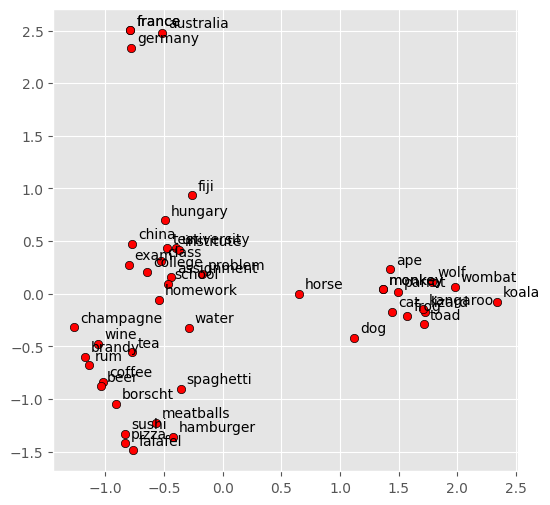

In [ ]:
display_pca_scatterplot(
    model, 
    [
        'coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
        'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
        'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
        'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
        'france', 'germany', 'hungary', 'france', 'australia', 'fiji', 'china',
        'homework', 'assignment', 'problem', 'exam', 'test', 'class',
        'school', 'college', 'university', 'institute'
    ]
)

### Information
- torchtext repo: https://github.com/pytorch/text/tree/main/torchtext
- torchtext documentation: https://pytorch.org/text/stable/index.html

In [44]:
# Where do I want to run my job. You can do "cuda" on linux machines.
DEVICE = "mps" if torch.backends.mps.is_available() else  "cpu"
# The batch size in Adam or SGD.
BATCH_SIZE = 512
# Number of epochs.
NUM_EPOCHS = 10
# Predict from 2 words the inner word for CBOW.
# I.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word).
# We'll predict each of wc = ["a", "c"] from "b" = wc for Skip-Gram.
# For CBOW, we'll use ["a", "c"] to predict "b" = wo.

# This is *NOT* used. This is "m" in lecture. It is random for each center word. See below.
WINDOW = 1

# Negative samples.
K = 4

The text8 Wikipedia corpus. 100M characters.

In [45]:
!du -h text8

 95M	text8


In [46]:
f = open('text8', 'r')
text = f.read()
# One big string of size 100M.
print(len(text))

100000000


In [47]:
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too.
for c in punc:
    if c in text:
        text.replace(c, ' ')

In [48]:
# A very crude tokenizer you get for free: lower case and also split on spaces.
TOKENIZER = get_tokenizer("basic_english")

In [49]:
words = TOKENIZER(text)
f = Counter(words)

In [50]:
len(words)

17005207

In [51]:
# Do a very crude filter on the text which remoes all words whuch 
text = [word for word in words if f[word] > 5]

In [52]:
text[0:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [53]:
VOCAB = build_vocab_from_iterator([text])

In [54]:
# word -> int hash map.
stoi = VOCAB.get_stoi()
# int -> word hash map.
itos = VOCAB.get_itos() 

In [55]:
stoi['as']

11

In [56]:
# Total number of words.
len(stoi)

63641

In [57]:
f = Counter(text)
# This is the probability that we pick a word in the corpus.
z = {word: f[word] / len(text) for word in f}

In [58]:
threshold = 1e-5
# Probability that word is kept while subsampling.
# This is explained here and sightly differet from the paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}

In [59]:
# This is in the integer space.
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary.
VOCAB = build_vocab_from_iterator([train_dataset])

In [60]:
len(train_dataset)

7848340

In [61]:
# word -> int mapping.
stoi = VOCAB.get_stoi()
# int -> word mapping.
itos = VOCAB.get_itos() 

In [62]:
# The vocabulary size after we do all the filters.
len(VOCAB)

63641

In [63]:
# The probability we draw something for negative sampling.
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))

# Downsample frequent words and upsample less frequent.
s = sum([np.power(freq, 0.75) for word, freq in f.items()])        

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

In [64]:
# Map everything to integers.
train_dataset = [stoi[word] for word in text]

In [65]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []
        
    for i, token in enumerate(dataset):
        # Pick a RANDOM window around the center word.
        m = random.randint(1, 5)
        
        start = max(0,i-m)
        
        end = min(i+m,len(dataset)-1)
        
        target_tokens = dataset[start:i] + dataset[i+1:end+1]
            
        wc = token
            
        x_list.extend([
            [wc, wo] for wo in target_tokens
        ])
            
    return x_list

In [66]:
train_x_list = get_tokenized_dataset(train_dataset, verbose=False)

In [67]:
#pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))

In [68]:
#train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))

In [69]:
# These are (wc, wo) pairs. All are y = +1 by design.
train_x_list[:10]

[[5233, 3083],
 [5233, 11],
 [3083, 5233],
 [3083, 11],
 [11, 5233],
 [11, 3083],
 [11, 6],
 [11, 210],
 [11, 1],
 [11, 3133]]

In [70]:
# The number of things of BATCH_SIZE = 512.
len(train_x_list) // BATCH_SIZE

195479

### Set up the dataloader.

In [71]:
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

### Words we'll use to asses the quality of the model ...

In [72]:
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

### Get the model.

In [73]:
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGramNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word.
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word.
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Not sure.
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size.
        # x is (N, 2)
        
        # Each of these is (N, 1)
        wc, wo = x[:, 0], x[:, 1]
        
        # Each of these is (N, 1, D) since each context has 1 word.
        a = self.A(wc)
        
        # Each of these is (N, 1, D) since each target has 1 word.
        b = self.B(wo)
                
        # The product between each context and target vector.
        # Each of these is (N, 1, D) since each batch has 1 word.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = (a * b).sum(axis=-1)
                
        return logits

In [74]:
@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight
        
    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V).
    # We do S x d (d x V) => S x D and sort by negative similarity.
    top_k = 10 # Top k items will be displayed.
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Set up the model

In [75]:
LR = 10.0
NUM_EPOCHS = 10
EMBED_DIM = 300

In [76]:
model = SkipGramNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
# Is this a good idea?
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

In [77]:
model

SkipGramNegativeSampling(
  (A): Embedding(63641, 300)
  (B): Embedding(63641, 300)
)

In [78]:
validate_embeddings(model, valid_ids, itos)

money: awoke, bhutto, femininity, psychotherapy, burali, stilgar, knit, autoerotic, limiting, disadvantaged
lion: camped, pluto, facilities, cancellous, millimeters, tristram, annihilate, detectives, craftsman, sehul
africa: umberto, concerti, salieri, rat, modifying, yamamoto, microbreweries, barges, cpsu, bodily
musician: surrender, restricting, mamet, pollination, lsa, provinces, eukaryote, dewolf, basso, doodles
dance: breckenridge, golfers, drying, maybe, narrative, gamers, berne, eggs, compounding, sojourn




### Train the model

In [79]:
ratios = []

def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500
    
    for idx, x_batch in tqdm(enumerate(dataloader)):
        
        x_batch = x_batch[0]
        
        batch_size = x_batch.shape[0]
                
        optimizer.zero_grad()
        
        logits = model(x_batch)
                
        # Get the positive samples loss. Notice we use weights here.
        positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())
        
        # For each batch, get some negative samples.
        # We need a total of len(y_batch) * 2* WINDOW * K samples across a batch.
        # We then reshape this batch.
        # These are effectively the output words.
        negative_samples = torch.multinomial(p, batch_size * K, replacement=True)
        print("negative_samples", negative_samples.size())
        
        # Repeat the center word enough times so we can merge as needed.
        # Repeat does not work on MPS apparently.
        wc = x_batch[:, 0].to("cpu").repeat(K).sort().values
        wo = negative_samples
        print("wc", wc.size())
        print("wo", wo.size())
        
        # Get the negative samples.
        x_batch_negative = torch.stack([wc, wo], axis=1).to(DEVICE)
        print("x_batch_negative", x_batch_negative.size())
        """
        Note the way we formulated the targets: they are all 0 since these are negative samples.
        We do the BCEWithLogitsLoss by hand basically here.
        Notice we sum across the negative samples, per positive word.
        
        This is literally the equation in the lecture notes.
        """
        negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
            batch_size, K
        ).sum(1).mean().neg().to(DEVICE)
        
        loss = (positive_loss + negative_loss).mean()
                
        # Get the gradients via back propagation. 
        loss.backward()
                        
        # Clip the gradients? Generally a good idea.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Used for optimization. This should be roughly 0.001, on average.
        # You can use this to see if your learning rate is right - you can also plot the loss performance.
        with torch.no_grad():
            r = [
                (LR * p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()
            ]
            ratios.append(r)  
        
        # Do an optimization step. Update the parameters A and B.
        optimizer.step()
        total_loss += loss.item()
        total_batches += 1
                
        if idx % log_interval == 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f} ".format(
                    epoch,
                    idx,
                    len(dataloader),
                    total_loss / total_batches
                )
            )
            validate_embeddings(model, valid_ids, itos)
            total_loss, total_batches = 0.0, 0.0

### Some results from the run look like below:

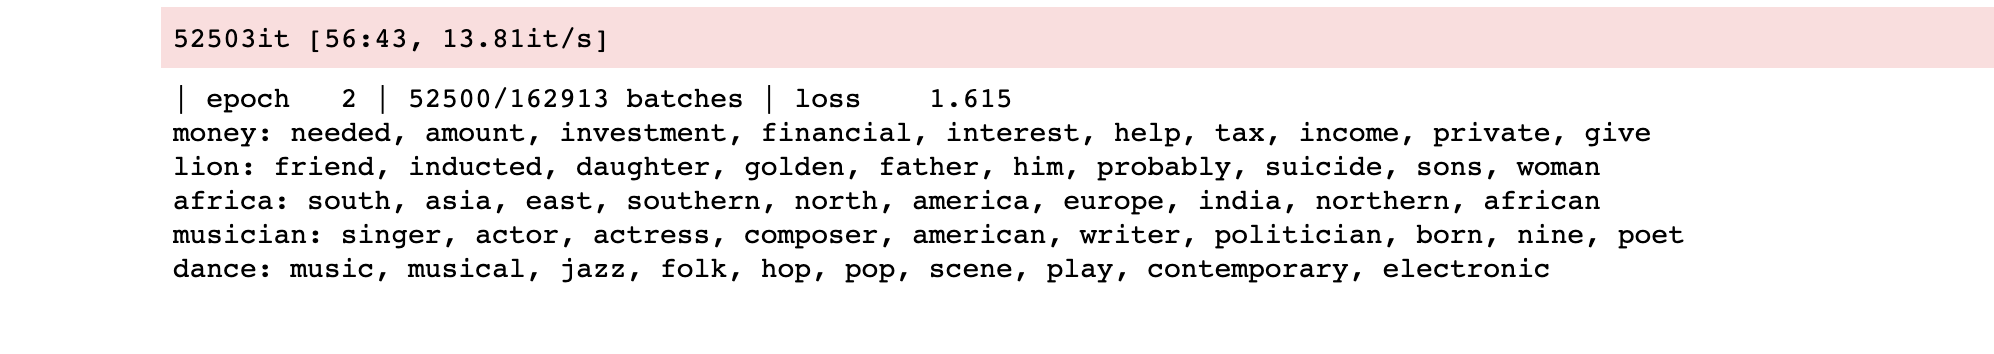

In [80]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    train(train_dl, model, optimizer, epoch)
    # We have a learning rate scheduler here.
    # Basically, given the state of the optimizer, this lowers the learning rate in a smart way.
    scheduler.step()

0it [00:00, ?it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
| epoch   1 |     0/195480 batches | loss    4.714 


2it [00:03,  1.52s/it]

money: awoke, bhutto, femininity, psychotherapy, burali, stilgar, knit, autoerotic, limiting, disadvantaged
lion: camped, pluto, facilities, cancellous, millimeters, tristram, annihilate, detectives, craftsman, sehul
africa: umberto, concerti, salieri, rat, modifying, yamamoto, microbreweries, barges, cpsu, bodily
musician: surrender, restricting, mamet, pollination, lsa, provinces, eukaryote, dewolf, basso, doodles
dance: breckenridge, golfers, drying, maybe, narrative, gamers, berne, eggs, compounding, sojourn


negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


3it [00:03,  1.14it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


7it [00:04,  2.89it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


9it [00:04,  4.04it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


11it [00:04,  5.18it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


15it [00:05,  7.27it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


17it [00:05,  8.23it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


21it [00:05,  9.35it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


25it [00:06, 10.24it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


27it [00:06, 10.48it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


31it [00:06, 10.73it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


33it [00:06, 10.86it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


35it [00:07, 10.86it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


37it [00:07, 10.46it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


41it [00:07, 10.50it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


43it [00:07, 10.58it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


47it [00:08, 10.78it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


49it [00:08, 10.98it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


53it [00:08, 10.89it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


57it [00:09, 11.05it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


59it [00:09, 11.02it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


61it [00:09, 10.97it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])
negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


63it [00:09,  6.46it/s]

negative_samples torch.Size([2048])
wc torch.Size([2048])
wo torch.Size([2048])
x_batch_negative torch.Size([2048, 2])


KeyboardInterrupt: 

### Some diagnostics.

Sometimes you want to add diagnostics to your NN.
- For each iteration, get the $L_2$ norm of the gradients* learning_rate and divide this by the parameters. This should be about -3 on the log scale, i.e. the ratio should be about 0.001. If the ratios are smaller, the learning rate might be too small, otherwise too large. Below we do this for the Skip-Gram model above.


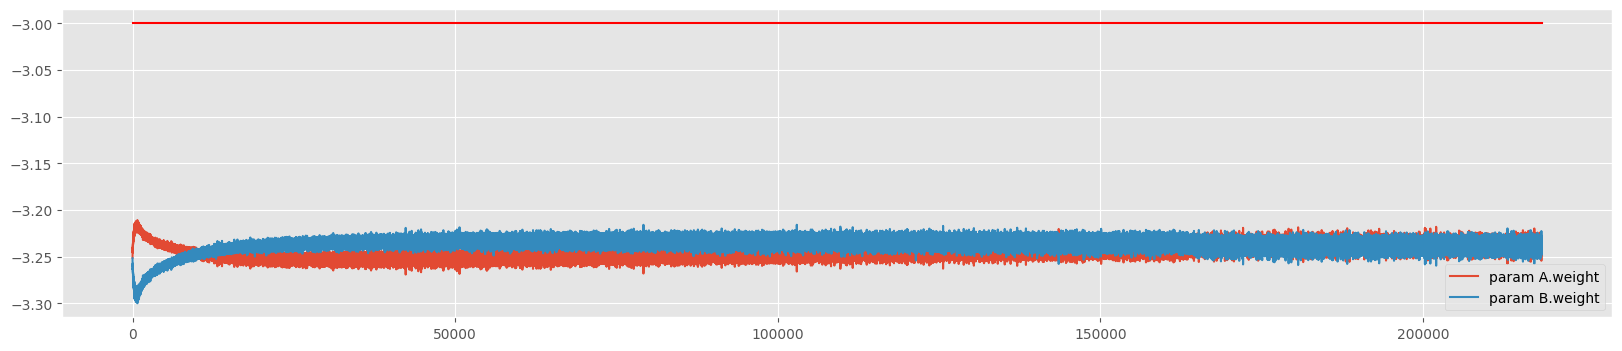

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
legends = []
for i, (name, p) in enumerate(model.named_parameters()):
    plt.plot([ratios[j][i] for j in range(len(ratios))])
    legends.append('param {}'.format(name))
plt.plot([0, len(ratios)], [-3, -3], 'r')
plt.legend(legends)

How do you make sure the learing rate is good? Look at the above plots and suppose we have $log(LR * ratio) = -5$. Then $LR * ratio = 10^{-5}$. Assuming the ratio does not vary much, this probably means we need to increase the learing rate $LR$. Similarly for a reverse direction.